# Experiments with real data (Bikes)

https://www.mdpi.com/2227-7390/9/18/2247

## Requirements

In [2]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from db_robust_clust.plots import clustering_MDS_plot_multiple_methods
from db_robust_clust.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'bikes_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_bikes import get_config as get_config_exp_1_bikes
from config_experiment_3_bikes import get_config as get_config_exp_3_bikes
from config_experiment_4_bikes import get_config as get_config_exp_4_bikes

## Data exploration


### Conceptual description


| Variable | Descripción | Rol | Tipo de Dato | Valores / Unidades |
| :--- | :--- | :--- | :--- | :--- |
| **cnt** | Conteo de **alquileres totales** de bicicletas (`casual` + `registered`). | **Target** | Numérica (entera) | Conteo de bicicletas. |
| **temp** | Temperatura normalizada en Celsius. | Feature | Numérica (continua) | Normalizada: $(t - t_{min})/(t_{max} - t_{min})$($t_{min} = -8$, $t_{max} = 39$). |
| **atemp** | Sensación térmica normalizada en Celsius. | Feature | Numérica (continua) | Normalizada: $(t - t_{min})/(t_{max} - t_{min})$($t_{min} = -16$, $t_{max} = 50$). |
| **windspeed** | Velocidad del viento normalizada. | Feature | Numérica (continua) | Normalizada (dividida por 67, max). |
| **season** | Estación del año. | Feature | Categórica (nominal) | `1`: Invierno, `2`: Primavera, `3`: Verano, `4`: Otoño. |
| **yr** | Año. | Feature | Categórica (nominal) | `0`: 2011, `1`: 2012, ..., `7`: 2018. |
| **mnth** | Mes. | Feature | Categórica (nominal) | 1 a 12. |
| **hr** | Hora del día (0 a 23). (Solo en datos por hora) | Feature | Categórica (nominal) | 0 a 23. |
| **holiday** | Indicador de día festivo. | Feature | **Binaria** | 0: No festivo, 1: Festivo. |
| **weekday** | Día de la semana. | Feature | Categórica (nominal) | 0 a 6 (ej. `0`: Domingo). |
| **workingday**| Indicador de si el día no es fin de semana ni festivo. | Feature | **Binaria** | 1: Día laborable, 0: Fin de semana o festivo. |
| **casual** | Conteo de usuarios casuales (no registrados). | Other | Numérica (entera) | Conteo de usuarios. |
| **registered**| Conteo de usuarios registrados. | Other | Numérica (entera) | Conteo de usuarios. |
| **dteday** | Fecha del registro. | Feature | Fecha | Fecha. |
| **AWND** | Velocidad promedio diaria del viento. | Feature | Numérica (continua) | Millas por hora (miles per hour). |
| **PRCP** | Precipitación. | Feature | Numérica (continua) | Pulgadas (inches a centésimas). |
| **TMAX** | Temperatura máxima diaria. | Feature | Numérica (entera) | Fahrenheit. |
| **TMIN** | Temperatura mínima diaria. | Feature | Numérica (entera) | Fahrenheit. |
| **Dewpt** | Temperatura media diaria. | Feature | Numérica (continua) | Celsius (Mean daily temperature). |
| **RHx** | Humedad relativa. | Feature | Numérica (continua) | Porcentaje (in %). |
| **Height** | Altura del techo / Cielo raso. | Feature | Numérica (continua) | Metros (meters). |
| **Visby** | Visibilidad. | Feature | Numérica (continua) | Unidades no especificadas (podría ser metros o millas). |
| **Slp** | Presión del nivel del mar. | Feature | Numérica (continua) | hPa (Hectopascales). |

### Data reading

In [7]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

df, X, y, p1, p2, p3, n_clusters, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [3]:
X.head()

AWND,PRCP,TMAX,TMIN,WindSpeed,Height,Visby,Temp,Dewpt,Slp,RHx,Atemp,holiday,workingday,season,yr,mnth,weekday
f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64
7.16,0.01,58,34,2.719,12000.647,14949.324,7.484,3.892,1019.853,78.162,12.028,0,0,1,0,1,6
10.96,0.06,59,34,4.665,1101.211,14220.0,11.163,7.928,1015.731,81.37,10.356,0,0,1,0,1,0
10.29,0.0,41,28,5.412,22000.0,16069.75,1.688,-10.316,1023.331,41.156,-2.483,0,1,1,0,1,1
6.49,0.0,43,25,3.084,15420.036,16069.75,0.494,-6.725,1018.384,58.938,-2.353,0,1,1,0,1,2
8.5,0.0,43,31,3.506,19603.333,16069.75,2.694,-8.387,1013.812,45.562,0.486,0,1,1,0,1,3


In [4]:
X.shape

(2962, 18)

In [5]:
y

cnt
i64
0
0
0
0
0
…
1
1
1


In [6]:
y.shape

(2962,)

In [7]:
n_clusters

3

In [8]:
print(p1, p2, p3)

12 2 4


In [9]:
encoding

{'cnt': {'low': 0, 'medium': 1, 'high': 2}}

In [10]:
quant_predictors

['AWND',
 'PRCP',
 'TMAX',
 'TMIN',
 'WindSpeed',
 'Height',
 'Visby',
 'Temp',
 'Dewpt',
 'Slp',
 'RHx',
 'Atemp']

In [11]:
binary_predictors

['holiday', 'workingday']

In [12]:
multiclass_predictors

['season', 'yr', 'mnth', 'weekday']

### Data description

In [13]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [14]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
AWND,91,0.0,8.36475,3.334767,1.12,4.7,6.04,7.83,10.29,12.97,29.97,4.282117,0.880606,0.020932
PRCP,163,0.0,0.118606,0.339893,0.0,0.0,0.0,0.0,0.04,0.38,4.0,37.262274,5.062478,0.195138
TMAX,86,0.0,67.926739,18.100335,19.0,43.0,53.0,69.0,84.0,90.0,105.0,2.060465,-0.261081,0.0
TMIN,79,0.0,51.279541,16.993836,5.0,30.0,37.0,51.0,67.0,73.0,84.0,1.935679,-0.134293,0.0
WindSpeed,2109,0.0,3.769008,1.495345,0.517,2.064,2.724,3.5915,4.571,5.77,11.361,4.044416,0.823002,0.025996
Height,2686,0.0,10205.021291,6559.652899,85.65,1592.415,4381.024,9625.603,15608.893,19787.692,22000.0,1.843893,0.201689,0.0
Visby,1291,0.0,14857.942662,2245.630568,2177.061,11576.582,14662.976,16069.75,16069.75,16071.118,16093.0,8.114755,-2.291726,0.134706
Temp,2797,0.0,15.045662,9.490675,-10.631,2.55,7.044,15.3075,23.776,27.03,33.762,1.984828,-0.194604,0.0
Dewpt,2794,0.0,7.539074,10.469102,-23.55,-6.83,-0.725,8.519,16.892,20.524,24.878,2.177174,-0.360769,0.0
Slp,2510,0.0,1017.868317,6.95547,985.383,1009.337,1013.403,1017.5255,1022.156,1026.942,1041.444,3.431663,0.116816,0.017893


In [15]:
cat_summary

,n_unique,perc_nan,mode
holiday,2,0.0,0
workingday,2,0.0,1
season,4,0.0,3
yr,9,0.0,1
mnth,12,0.0,1
weekday,7,0.0,3


In [16]:
y.describe()

statistic,value
str,f64
"""count""",2962.0
"""null_count""",0.0
"""mean""",1.000338
"""std""",0.707226
"""min""",0.0
"""25%""",1.0
"""50%""",1.0
"""75%""",2.0
"""max""",2.0


In [18]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = np.round(counts/len(y), 2)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.25, 1: 0.5, 2: 0.25}


In [28]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""AWND""",-0.335,16.665,62,2900,0.020932,0.979068
"""PRCP""",-0.06,0.1,578,2384,0.195138,0.804862
"""TMAX""",6.5,130.5,0,2962,0.0,1.0
"""TMIN""",-8.0,112.0,0,2962,0.0,1.0
"""WindSpeed""",-0.0465,7.3415,77,2885,0.025996,0.974004
…,…,…,…,…,…,…
"""Temp""",-18.054,48.874,0,2962,0.0,1.0
"""Dewpt""",-27.1505,43.3175,0,2962,0.0,1.0
"""Slp""",1000.2735,1035.2855,53,2909,0.017893,0.982107


In [29]:
outliers_df['prop_outliers'].mean()

0.03291694800810264

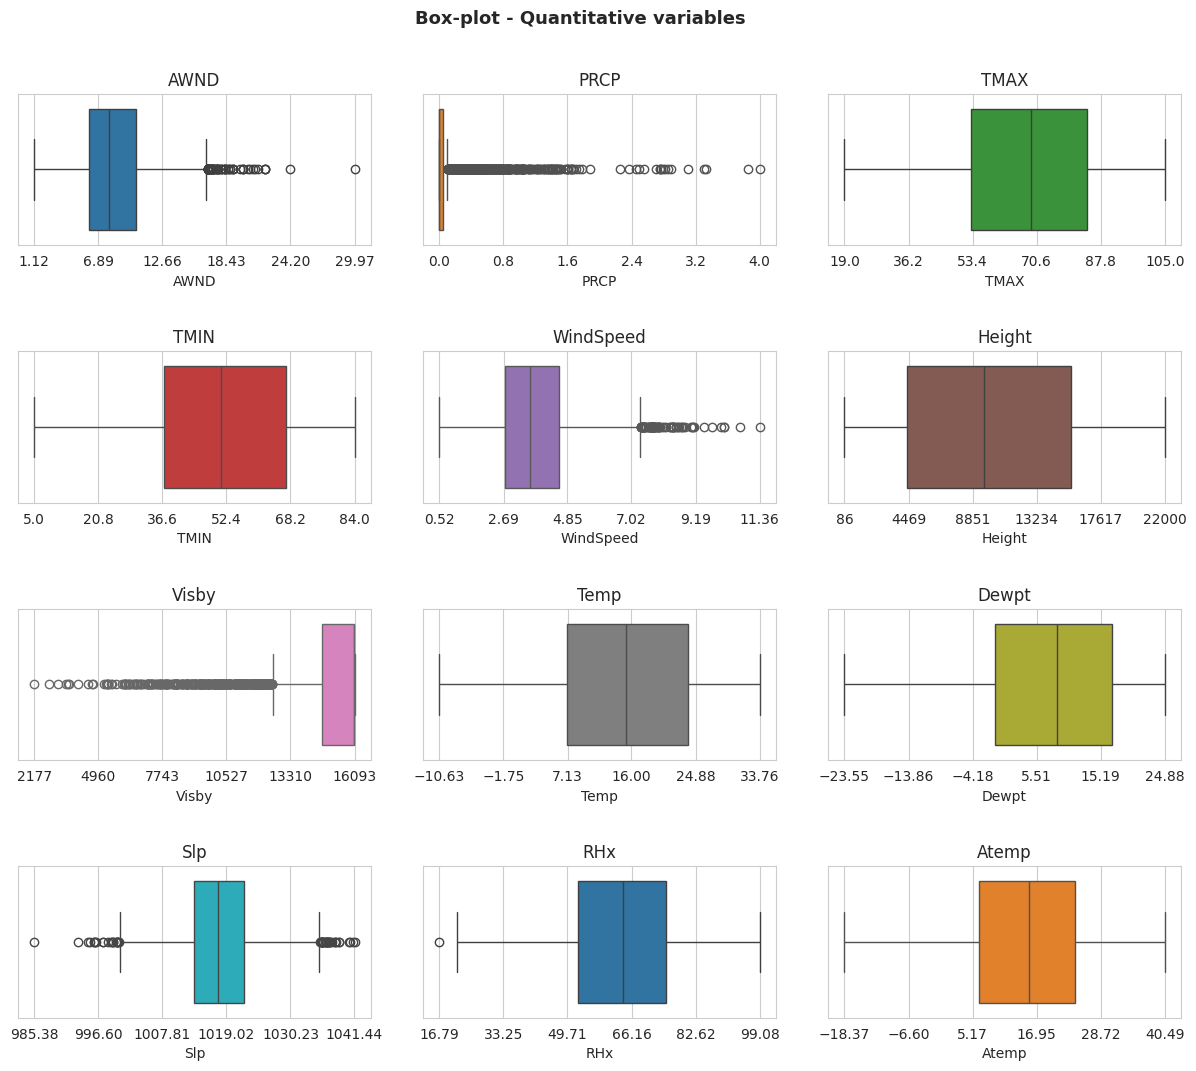

In [30]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,12), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

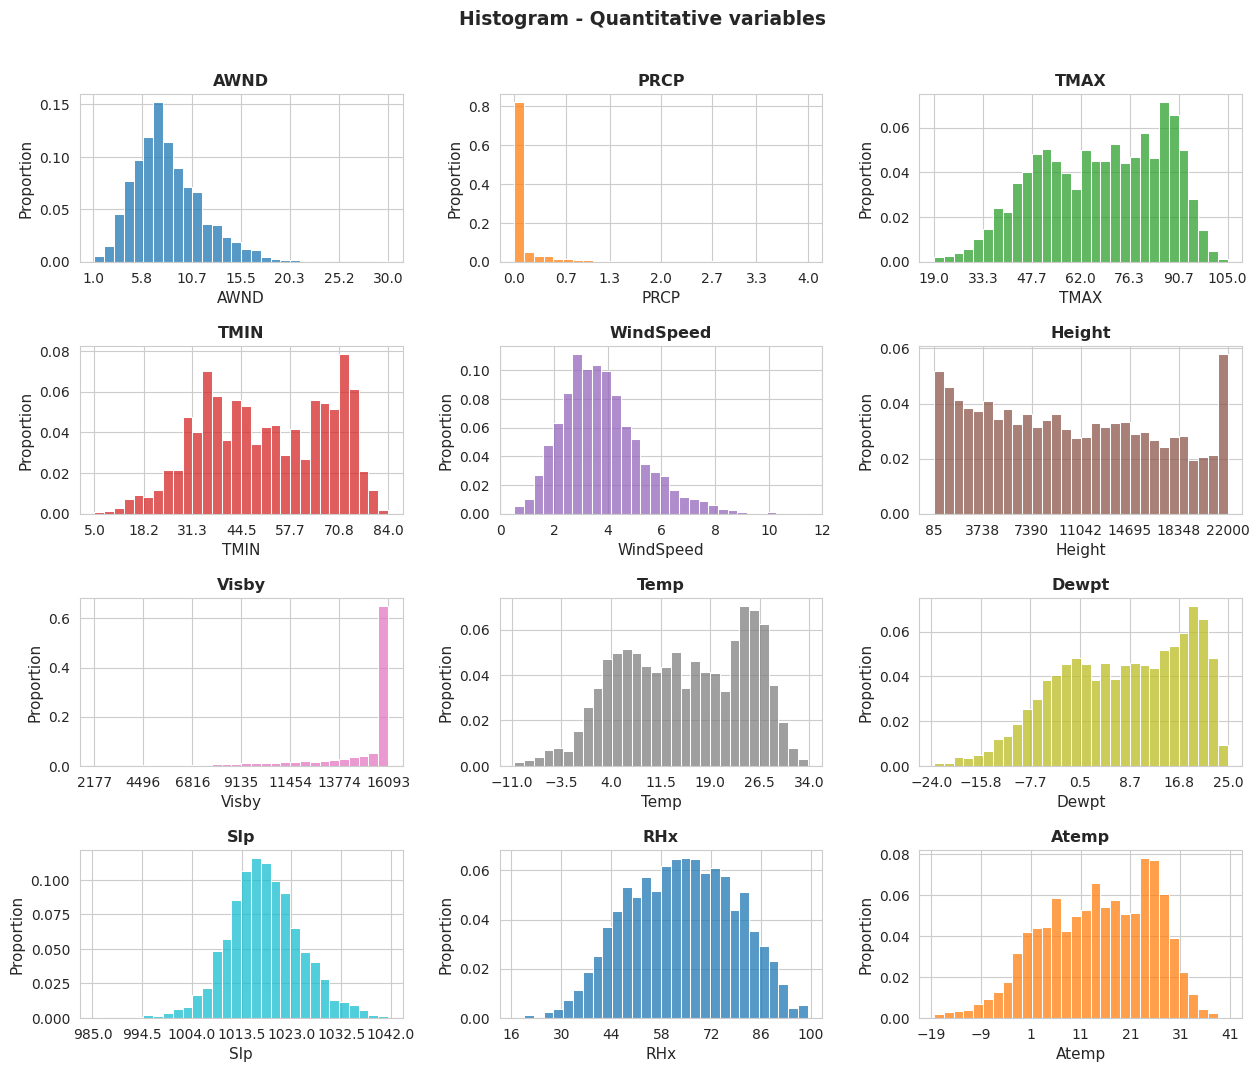

In [31]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,12), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.95,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

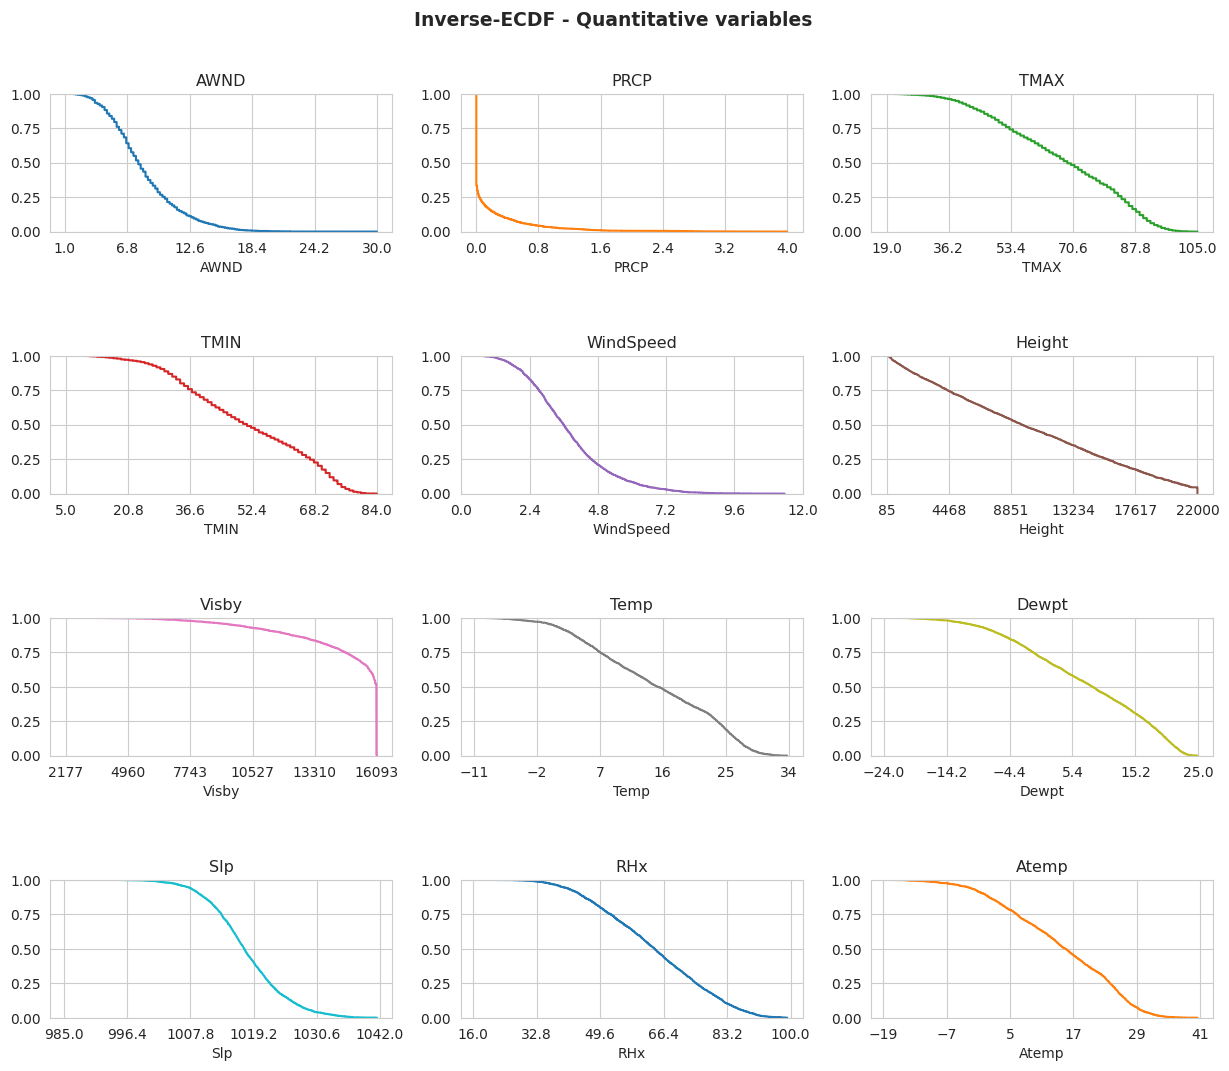

In [32]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,12), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=0.95,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10,
            ) 

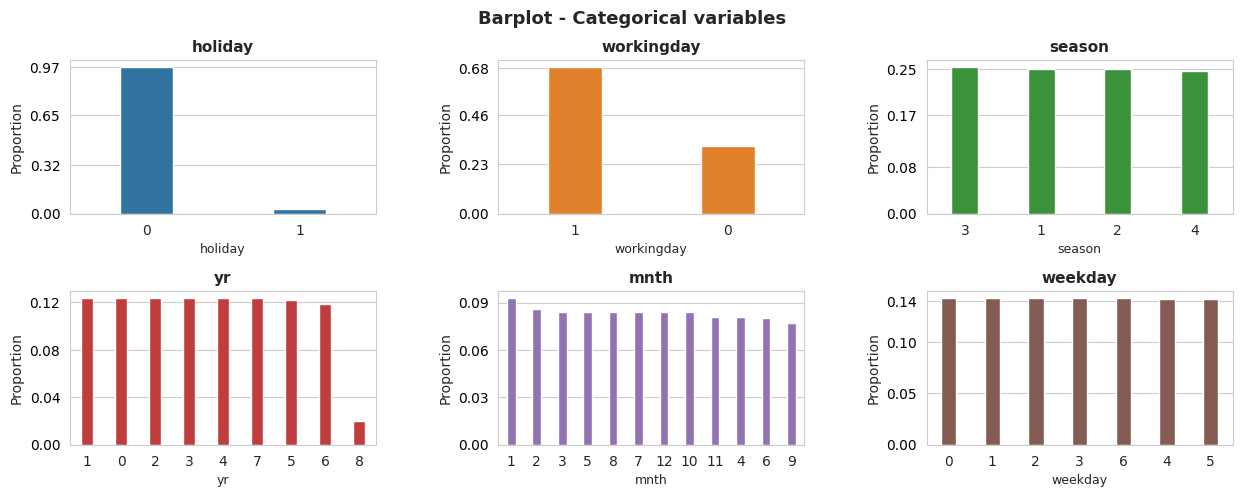

In [33]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,5), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.98,
               style='whitegrid', 
               hspace=0.5, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [34]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,AWND,PRCP,TMAX,TMIN,WindSpeed,Height,Visby,Temp,Dewpt,Slp,RHx,Atemp
AWND,1.000000,0.090845,-0.194529,-0.198528,0.923582,-0.065799,-0.029756,-0.167134,-0.200131,-0.297969,-0.149933,-0.234329
PRCP,0.090845,1.000000,0.025450,0.087710,0.103525,-0.367105,-0.497438,0.060472,0.176997,-0.171573,0.372736,0.058684
TMAX,-0.194529,0.025450,1.000000,0.945231,-0.208474,0.084789,0.185294,0.977086,0.907154,-0.315728,0.205862,0.972328
TMIN,-0.198528,0.087710,0.945231,1.000000,-0.194297,-0.075488,0.090229,0.982532,0.953031,-0.319485,0.315870,0.971779
WindSpeed,0.923582,0.103525,-0.208474,-0.194297,1.000000,-0.020573,0.020243,-0.172081,-0.228557,-0.260799,-0.224514,-0.249924
Height,-0.065799,-0.367105,0.084789,-0.075488,-0.020573,1.000000,0.534513,0.014235,-0.210610,0.236626,-0.635659,0.009384
Visby,-0.029756,-0.497438,0.185294,0.090229,0.020243,0.534513,1.000000,0.152406,-0.062475,0.142053,-0.604347,0.138906
Temp,-0.167134,0.060472,0.977086,0.982532,-0.172081,0.014235,0.152406,1.000000,0.940141,-0.336603,0.240136,0.989535
Dewpt,-0.200131,0.176997,0.907154,0.953031,-0.228557,-0.210610,-0.062475,0.940141,1.000000,-0.364368,0.552828,0.941231
Slp,-0.297969,-0.171573,-0.315728,-0.319485,-0.260799,0.236626,0.142053,-0.336603,-0.364368,1.000000,-0.238855,-0.315386


In [35]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.2
Proportion of pair-wise correlations in [0.30, 0.60]:  0.17
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.64


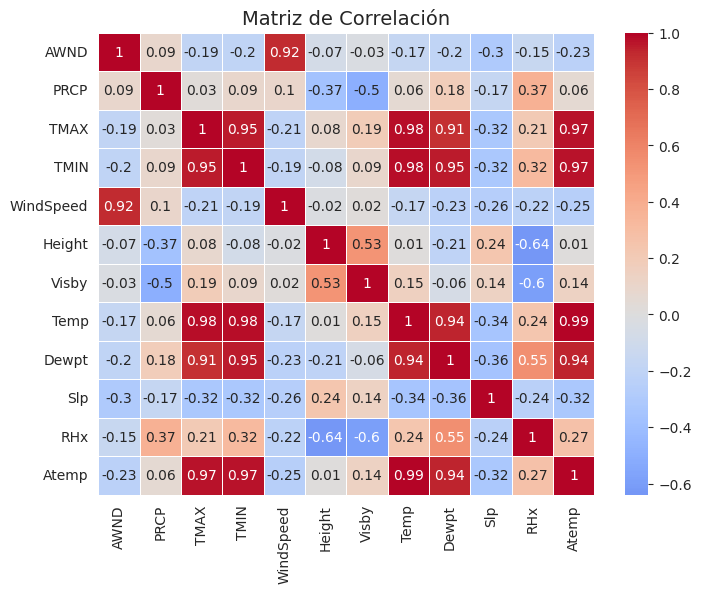

In [36]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()


## Experiment 1


In [1]:
run_experiment_1 = True

In [93]:
if run_experiment_1: 
        
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'bikes')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_130045'

    config_exp_1 = get_config_exp_1_bikes()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [95]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score #accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 41 mins

chunks:   0%|          | 0/20 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427, 53377, 34937]
random_state: 6863
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 35084
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 11427
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0

chunks:   5%|▌         | 1/20 [02:40<50:45, 160.28s/chunks]

len y_pred: 3
random_state_chunk: [14116, 5000, 49692, 70281, 73704]
random_state: 14116
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 5000
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 49692
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  10%|█         | 2/20 [05:16<47:26, 158.12s/chunks]

len y_pred: 3
random_state_chunk: [43541, 44669, 6802, 20927, 17702]
random_state: 43541
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 44669
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 6802
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  15%|█▌        | 3/20 [08:03<45:55, 162.12s/chunks]

len y_pred: 3
random_state_chunk: [44199, 73526, 43751, 91971, 32134]
random_state: 44199
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 73526
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 43751
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
fra

chunks:  20%|██        | 4/20 [10:33<41:53, 157.07s/chunks]

len y_pred: 3
random_state_chunk: [21466, 218, 57183, 11483, 78328]
random_state: 21466
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 218
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 57183
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sa

chunks:  25%|██▌       | 5/20 [13:16<39:53, 159.53s/chunks]

len y_pred: 3
random_state_chunk: [49492, 9158, 864, 41347, 95949]
random_state: 49492
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 9158
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 864
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_samp

chunks:  30%|███       | 6/20 [15:55<37:09, 159.27s/chunks]

len y_pred: 3
random_state_chunk: [58762, 13374, 5752, 12158, 87443]
random_state: 58762
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 13374
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 5752
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  35%|███▌      | 7/20 [18:36<34:34, 159.61s/chunks]

len y_pred: 3
random_state_chunk: [18635, 16547, 2783, 38247, 56444]
random_state: 18635
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 16547
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 2783
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  40%|████      | 8/20 [21:10<31:35, 157.94s/chunks]

len y_pred: 3
random_state_chunk: [75157, 62511, 34776, 61511, 4816]
random_state: 75157
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 62511
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 34776
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac

chunks:  45%|████▌     | 9/20 [23:44<28:43, 156.69s/chunks]

len y_pred: 3
random_state_chunk: [39989, 45018, 68376, 63302, 27113]
random_state: 39989
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 45018
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 68376
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
fra

chunks:  50%|█████     | 10/20 [26:24<26:18, 157.85s/chunks]

len y_pred: 3
random_state_chunk: [79810, 83723, 69084, 74031, 41322]
random_state: 79810
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 83723
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 69084
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
fra

chunks:  55%|█████▌    | 11/20 [28:55<23:22, 155.80s/chunks]

len y_pred: 3
random_state_chunk: [1644, 52197, 84692, 67207, 56935]
random_state: 1644
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 52197
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 84692
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  60%|██████    | 12/20 [31:35<20:55, 156.99s/chunks]

len y_pred: 3
random_state_chunk: [89762, 70584, 83670, 87380, 78185]
random_state: 89762
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 70584
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 83670
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
fra

chunks:  65%|██████▌   | 13/20 [34:10<18:15, 156.44s/chunks]

len y_pred: 3
random_state_chunk: [63718, 68237, 87617, 54984, 49089]
random_state: 63718
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 68237
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 87617
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
fra

chunks:  70%|███████   | 14/20 [36:53<15:50, 158.39s/chunks]

len y_pred: 3
random_state_chunk: [66855, 4173, 98850, 84600, 23784]
random_state: 66855
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 4173
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 98850
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  75%|███████▌  | 15/20 [39:28<13:05, 157.14s/chunks]

len y_pred: 3
random_state_chunk: [95135, 10827, 63819, 86255, 34326]
random_state: 95135
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 10827
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 63819
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
fra

chunks:  80%|████████  | 16/20 [42:05<10:29, 157.39s/chunks]

len y_pred: 3
random_state_chunk: [22298, 43896, 44160, 72640, 51274]
random_state: 22298
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 43896
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 44160
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
fra

chunks:  85%|████████▌ | 17/20 [44:40<07:49, 156.56s/chunks]

len y_pred: 3
random_state_chunk: [9606, 94779, 59869, 50810, 75126]
random_state: 9606
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 94779
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 59869
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  90%|█████████ | 18/20 [47:17<05:13, 156.52s/chunks]

len y_pred: 3
random_state_chunk: [44054, 2137, 24780, 76834, 11554]
random_state: 44054
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 2137
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 24780
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks:  95%|█████████▌| 19/20 [49:52<02:36, 156.12s/chunks]

len y_pred: 3
random_state_chunk: [82354, 47646, 1681, 46126, 30032]
random_state: 82354
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 47646
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
frac_sample_size: 0.4
len y_pred: 3
frac_sample_size: 0.5
len y_pred: 3
frac_sample_size: 0.6
len y_pred: 3
frac_sample_size: 0.7
len y_pred: 3
frac_sample_size: 0.8
len y_pred: 3
frac_sample_size: 0.9
len y_pred: 3
frac_sample_size: 1.0
len y_pred: 3
random_state: 1681
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_

chunks: 100%|██████████| 20/20 [52:25<00:00, 157.27s/chunks]

len y_pred: 3


In [96]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'bikes')
    file_id = '20250930_130045'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_bikes_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [4]:
# Open merged/joined results 

file_id = '20250930_130045'
results_filename = f'results_exp_1_bikes_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'bikes')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [5]:
experiment_1_config = get_config_exp_1_bikes()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [6]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

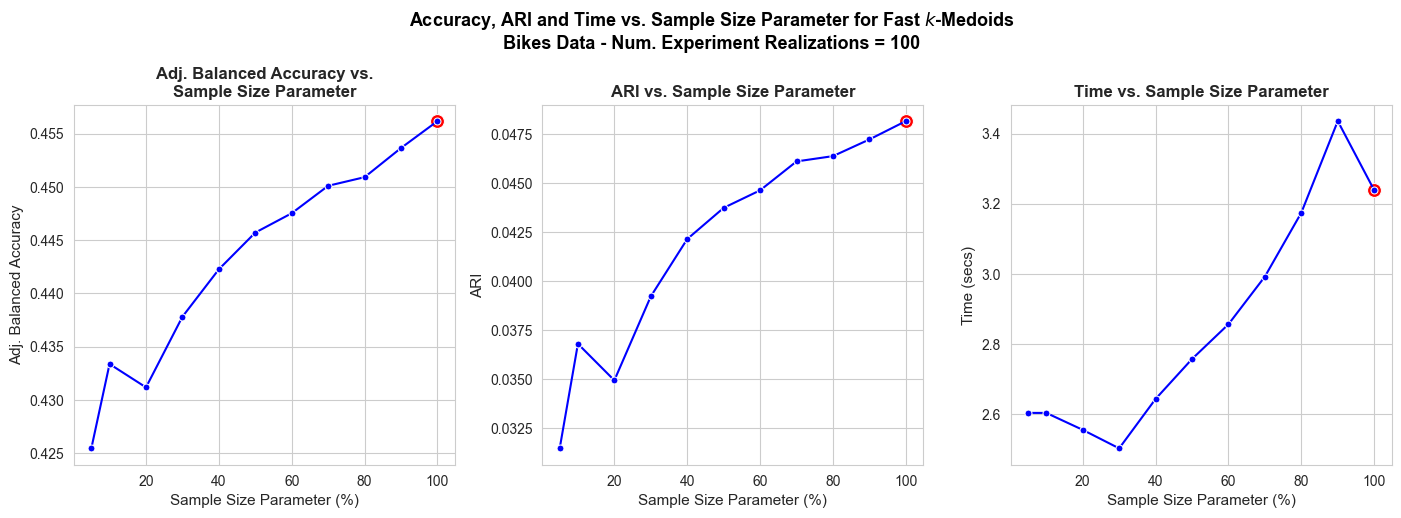

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Balanced Accuracy vs.\nSample Size Parameter', size=12, weight='bold')
axes[0].set_ylabel('Adj. Balanced Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size Parameter', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size Parameter', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample Size Parameter for Fast $k$-Medoids\nBikes Data - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_bikes_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [8]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.05,2.603857,0.425444,0.031475
0.10,2.603785,0.433364,0.036805
0.20,2.555540,0.431171,0.034941
0.30,2.502800,0.437805,0.039222
0.40,2.643641,0.442257,0.042147
0.50,2.757445,0.445704,0.043738
0.60,2.856473,0.447521,0.044632
0.70,2.992402,0.450098,0.046105
0.80,3.174467,0.450908,0.046375


In [9]:
print(best_frac_sample_size)

1.0



## Experiment 3


In [10]:
run_experiment_3 = True

In [104]:
if run_experiment_3: 

    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'bikes')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_155234'

    config_exp_3 = get_config_exp_3_bikes()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [105]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score #accuracy_score  
                                                )

        # Save results
        results_filename = f'results_exp_3_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 50 mins

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427]
random_state: 6863
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


random_state: 35084
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


random_state: 11427
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


frac_sample_size: 1.0


chunks:   3%|▎         | 1/34 [20:55<11:30:47, 1255.99s/chunks]

random_state_chunk: [53377, 34937, 14116]
random_state: 53377
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


random_state: 34937
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


random_state: 14116
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 1.0


chunks:   6%|▌         | 2/34 [41:23<11:00:54, 1239.21s/chunks]

random_state_chunk: [5000, 49692, 70281]
random_state: 5000
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


random_state: 49692
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


random_state: 70281
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


chunks:   9%|▉         | 3/34 [1:01:42<10:35:34, 1230.16s/chunks]

random_state_chunk: [73704, 43541, 44669]
random_state: 73704
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 43541
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.60s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


random_state: 44669
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


frac_sample_size: 1.0


chunks:  12%|█▏        | 4/34 [1:22:22<10:17:01, 1234.06s/chunks]

random_state_chunk: [6802, 20927, 17702]
random_state: 6802
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 20927
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


random_state: 17702
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 1.0


chunks:  15%|█▍        | 5/34 [1:42:54<9:56:00, 1233.12s/chunks] 

random_state_chunk: [44199, 73526, 43751]
random_state: 44199
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


random_state: 73526
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


random_state: 43751
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:27<00:00,  1.80s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


chunks:  18%|█▊        | 6/34 [2:03:31<9:36:03, 1234.43s/chunks]

random_state_chunk: [91971, 32134, 21466]
random_state: 91971
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


random_state: 32134
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


random_state: 21466
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 1.0


chunks:  21%|██        | 7/34 [2:24:22<9:17:54, 1239.78s/chunks]

random_state_chunk: [218, 57183, 11483]
random_state: 218
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


random_state: 57183
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


random_state: 11483
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  24%|██▎       | 8/34 [2:45:07<8:58:04, 1241.72s/chunks]

random_state_chunk: [78328, 49492, 9158]
random_state: 78328
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 49492
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 9158
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  26%|██▋       | 9/34 [3:05:26<8:34:22, 1234.51s/chunks]

random_state_chunk: [864, 41347, 95949]
random_state: 864
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


random_state: 41347
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 95949
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


frac_sample_size: 1.0


chunks:  29%|██▉       | 10/34 [3:25:51<8:12:37, 1231.58s/chunks]

random_state_chunk: [58762, 13374, 5752]
random_state: 58762
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 13374
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


random_state: 5752
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  32%|███▏      | 11/34 [3:46:10<7:50:36, 1227.67s/chunks]

random_state_chunk: [12158, 87443, 18635]
random_state: 12158
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 87443
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 18635
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  35%|███▌      | 12/34 [4:06:27<7:28:58, 1224.48s/chunks]

random_state_chunk: [16547, 2783, 38247]
random_state: 16547
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


random_state: 2783
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


random_state: 38247
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


frac_sample_size: 1.0


chunks:  38%|███▊      | 13/34 [4:26:52<7:08:37, 1224.63s/chunks]

random_state_chunk: [56444, 75157, 62511]
random_state: 56444
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


random_state: 75157
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 62511
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  41%|████      | 14/34 [4:47:14<6:47:56, 1223.81s/chunks]

random_state_chunk: [34776, 61511, 4816]
random_state: 34776
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 61511
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 4816
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  44%|████▍     | 15/34 [5:07:26<6:26:26, 1220.33s/chunks]

random_state_chunk: [39989, 45018, 68376]
random_state: 39989
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


random_state: 45018
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.60s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 68376
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 1.0


chunks:  47%|████▋     | 16/34 [5:27:43<6:05:46, 1219.27s/chunks]

random_state_chunk: [63302, 27113, 79810]
random_state: 63302
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


random_state: 27113
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


random_state: 79810
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  50%|█████     | 17/34 [5:48:03<5:45:31, 1219.47s/chunks]

random_state_chunk: [83723, 69084, 74031]
random_state: 83723
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


random_state: 69084
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 74031
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  53%|█████▎    | 18/34 [6:08:19<5:24:54, 1218.41s/chunks]

random_state_chunk: [41322, 1644, 52197]
random_state: 41322
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


random_state: 1644
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 52197
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  56%|█████▌    | 19/34 [6:28:34<5:04:21, 1217.43s/chunks]

random_state_chunk: [84692, 67207, 56935]
random_state: 84692
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 67207
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 56935
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  59%|█████▉    | 20/34 [6:48:02<4:40:33, 1202.42s/chunks]

random_state_chunk: [89762, 70584, 83670]
random_state: 89762
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


random_state: 70584
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 83670
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  62%|██████▏   | 21/34 [7:07:23<4:17:52, 1190.16s/chunks]

random_state_chunk: [87380, 78185, 63718]
random_state: 87380
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


random_state: 78185
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


random_state: 63718
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 1.0


chunks:  65%|██████▍   | 22/34 [7:26:51<3:56:41, 1183.43s/chunks]

random_state_chunk: [68237, 87617, 54984]
random_state: 68237
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 87617
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


random_state: 54984
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  68%|██████▊   | 23/34 [7:46:16<3:35:57, 1178.00s/chunks]

random_state_chunk: [49089, 66855, 4173]
random_state: 49089
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 66855
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 4173
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  71%|███████   | 24/34 [8:05:39<3:15:33, 1173.31s/chunks]

random_state_chunk: [98850, 84600, 23784]
random_state: 98850
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


random_state: 84600
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


random_state: 23784
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


chunks:  74%|███████▎  | 25/34 [8:25:01<2:55:29, 1169.97s/chunks]

random_state_chunk: [95135, 10827, 63819]
random_state: 95135
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 10827
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 63819
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  76%|███████▋  | 26/34 [8:44:20<2:35:33, 1166.71s/chunks]

random_state_chunk: [86255, 34326, 22298]
random_state: 86255
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 34326
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 22298
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


chunks:  79%|███████▉  | 27/34 [9:03:41<2:15:56, 1165.17s/chunks]

random_state_chunk: [43896, 44160, 72640]
random_state: 43896
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


random_state: 44160
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 72640
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 1.0


chunks:  82%|████████▏ | 28/34 [9:22:57<1:56:13, 1162.25s/chunks]

random_state_chunk: [51274, 9606, 94779]
random_state: 51274
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 9606
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 94779
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  85%|████████▌ | 29/34 [9:42:09<1:36:35, 1159.18s/chunks]

random_state_chunk: [59869, 50810, 75126]
random_state: 59869
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 50810
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 75126
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  88%|████████▊ | 30/34 [10:01:19<1:17:06, 1156.60s/chunks]

random_state_chunk: [44054, 2137, 24780]
random_state: 44054
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 2137
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


random_state: 24780
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  91%|█████████ | 31/34 [10:20:29<57:43, 1154.60s/chunks]  

random_state_chunk: [76834, 11554, 82354]
random_state: 76834
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


random_state: 11554
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 82354
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


chunks:  94%|█████████▍| 32/34 [10:39:41<38:27, 1153.63s/chunks]

random_state_chunk: [47646, 1681, 46126]
random_state: 47646
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 1681
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


random_state: 46126
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks:  97%|█████████▋| 33/34 [10:58:55<19:13, 1153.72s/chunks]

random_state_chunk: [30032]
random_state: 30032
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


frac_sample_size: 1.0


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


frac_sample_size: 1.0


chunks: 100%|██████████| 34/34 [11:05:18<00:00, 1174.06s/chunks]


In [106]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20250930_155234'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_bikes_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [11]:
# Open merged/joined results 

file_id = '20250930_155234'
results_filename = f'results_exp_3_bikes_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'bikes')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [12]:
config_exp_3 = get_config_exp_3_bikes()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

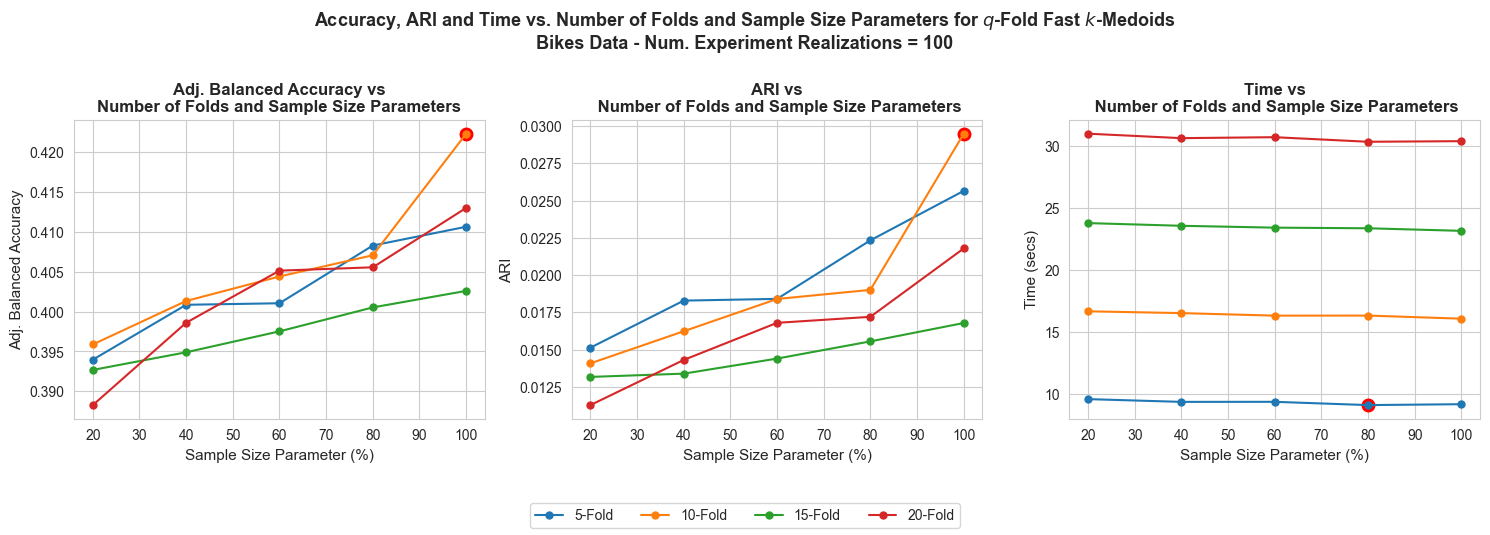

In [15]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Balanced Accuracy vs\nNumber of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Balanced Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of Folds and Sample Size Parameters for $q$-Fold Fast $k$-Medoids\nBikes Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_bikes_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [17]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.2,0.393968,0.015125,9.592318
1,5,0.4,0.400849,0.018286,9.370440
2,5,0.6,0.401040,0.018402,9.375281
3,5,0.8,0.408278,0.022335,9.110620
4,5,1.0,0.410629,0.025657,9.182464
5,10,0.2,0.395878,0.014072,16.675536
6,10,0.4,0.401327,0.016229,16.531647
7,10,0.6,0.404397,0.018396,16.326020
8,10,0.8,0.407058,0.019008,16.331488
9,10,1.0,0.422295,0.029497,16.081921


In [18]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 0.338 
 best_n_splits 10.0 
 best_frac_sample_size 1.0



## Experiment 4

In [9]:
config_exp_4 = get_config_exp_4_bikes()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 100
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state,),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),

        #'DipInit': DipInit(n_clusters=config_exp_4['n_clusters'],
        #                    random_state=random_state),

        #'SpectralClustering': SpectralClustering(n_clusters=config_exp_4['n_clusters'],
        #                                         random_state=random_state)
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            label_model_name = f'{d1}_{r}-{d2}-{d3}'
        else:
            r = None
            label_model_name = f'{d1}-{d2}-{d3}'
            
        models[random_state][f'FastKmedoidsGGower-{label_model_name}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{label_model_name}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [63]:
run_experiment_4 = True

In [64]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'bikes')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251001_121615'

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [ ]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=balanced_accuracy_score # accuracy_score
                )

        # Save results
        results_filename = f'results_exp_4_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 200 mins

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [6863, 35084, 11427]
random_state: 6863
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


len y_pred: 3
random_state: 35084
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 11427
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   3%|▎         | 1/34 [05:13<2:52:22, 313.40s/chunks]

len y_pred: 3
chunk_id 1
random_state_chunk: [53377, 34937, 14116]
random_state: 53377
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 34937
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
random_state: 14116
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   6%|▌         | 2/34 [10:25<2:46:51, 312.87s/chunks]

len y_pred: 3
chunk_id 2
random_state_chunk: [5000, 49692, 70281]
random_state: 5000
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 49692
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 70281
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   9%|▉         | 3/34 [15:40<2:41:57, 313.45s/chunks]

len y_pred: 3
chunk_id 3
random_state_chunk: [73704, 43541, 44669]
random_state: 73704
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 43541
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 44669
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  12%|█▏        | 4/34 [20:52<2:36:32, 313.07s/chunks]

len y_pred: 3
chunk_id 4
random_state_chunk: [6802, 20927, 17702]
random_state: 6802
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 20927
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 17702
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  15%|█▍        | 5/34 [26:03<2:30:53, 312.20s/chunks]

len y_pred: 3
chunk_id 5
random_state_chunk: [44199, 73526, 43751]
random_state: 44199
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 73526
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 43751
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  18%|█▊        | 6/34 [31:17<2:26:02, 312.96s/chunks]

len y_pred: 3
chunk_id 6
random_state_chunk: [91971, 32134, 21466]
random_state: 91971
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 32134
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 21466
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  21%|██        | 7/34 [36:30<2:20:51, 313.01s/chunks]

len y_pred: 3
chunk_id 7
random_state_chunk: [218, 57183, 11483]
random_state: 218
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 57183
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 11483
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  24%|██▎       | 8/34 [41:44<2:15:41, 313.12s/chunks]

len y_pred: 3
chunk_id 8
random_state_chunk: [78328, 49492, 9158]
random_state: 78328
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 49492
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 9158
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  26%|██▋       | 9/34 [46:56<2:10:21, 312.84s/chunks]

len y_pred: 3
chunk_id 9
random_state_chunk: [864, 41347, 95949]
random_state: 864
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
random_state: 41347
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 95949
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  29%|██▉       | 10/34 [52:09<2:05:13, 313.07s/chunks]

len y_pred: 3
chunk_id 10
random_state_chunk: [58762, 13374, 5752]
random_state: 58762
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 13374
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 5752
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  32%|███▏      | 11/34 [57:26<2:00:22, 314.03s/chunks]

len y_pred: 3
chunk_id 11
random_state_chunk: [12158, 87443, 18635]
random_state: 12158
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


len y_pred: 3
random_state: 87443
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
random_state: 18635
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  35%|███▌      | 12/34 [1:02:59<1:57:19, 319.96s/chunks]

len y_pred: 3
chunk_id 12
random_state_chunk: [16547, 2783, 38247]
random_state: 16547
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 2783
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 38247
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  38%|███▊      | 13/34 [1:08:13<1:51:19, 318.06s/chunks]

len y_pred: 3
chunk_id 13
random_state_chunk: [56444, 75157, 62511]
random_state: 56444
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 75157
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 62511
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  41%|████      | 14/34 [1:13:28<1:45:41, 317.07s/chunks]

len y_pred: 3
chunk_id 14
random_state_chunk: [34776, 61511, 4816]
random_state: 34776
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 61511
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
random_state: 4816
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  44%|████▍     | 15/34 [1:18:41<1:40:04, 316.01s/chunks]

len y_pred: 3
chunk_id 15
random_state_chunk: [39989, 45018, 68376]
random_state: 39989
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 45018
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 68376
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  47%|████▋     | 16/34 [1:23:54<1:34:30, 315.01s/chunks]

len y_pred: 3
chunk_id 16
random_state_chunk: [63302, 27113, 79810]
random_state: 63302
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 27113
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 79810
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  50%|█████     | 17/34 [1:29:07<1:29:05, 314.46s/chunks]

len y_pred: 3
chunk_id 17
random_state_chunk: [83723, 69084, 74031]
random_state: 83723
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 69084
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 74031
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  53%|█████▎    | 18/34 [1:34:39<1:25:15, 319.72s/chunks]

len y_pred: 3
chunk_id 18
random_state_chunk: [41322, 1644, 52197]
random_state: 41322
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 1644
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 52197
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  56%|█████▌    | 19/34 [1:39:51<1:19:22, 317.51s/chunks]

len y_pred: 3
chunk_id 19
random_state_chunk: [84692, 67207, 56935]
random_state: 84692
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 67207
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 56935
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  59%|█████▉    | 20/34 [1:45:02<1:13:37, 315.51s/chunks]

len y_pred: 3
chunk_id 20
random_state_chunk: [89762, 70584, 83670]
random_state: 89762
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 70584
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 83670
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  62%|██████▏   | 21/34 [1:50:15<1:08:10, 314.64s/chunks]

len y_pred: 3
chunk_id 21
random_state_chunk: [87380, 78185, 63718]
random_state: 87380
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 78185
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 63718
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  65%|██████▍   | 22/34 [1:55:29<1:02:54, 314.50s/chunks]

len y_pred: 3
chunk_id 22
random_state_chunk: [68237, 87617, 54984]
random_state: 68237
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 87617
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 54984
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  68%|██████▊   | 23/34 [2:00:41<57:31, 313.81s/chunks]  

len y_pred: 3
chunk_id 23
random_state_chunk: [49089, 66855, 4173]
random_state: 49089
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
random_state: 66855
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 4173
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  71%|███████   | 24/34 [2:05:55<52:18, 313.81s/chunks]

len y_pred: 3
chunk_id 24
random_state_chunk: [98850, 84600, 23784]
random_state: 98850
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


len y_pred: 3
random_state: 84600
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
random_state: 23784
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  74%|███████▎  | 25/34 [2:11:23<47:43, 318.18s/chunks]

len y_pred: 3
chunk_id 25
random_state_chunk: [95135, 10827, 63819]
random_state: 95135
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
random_state: 10827
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
random_state: 63819
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  76%|███████▋  | 26/34 [2:16:36<42:11, 316.40s/chunks]

len y_pred: 3
chunk_id 26
random_state_chunk: [86255, 34326, 22298]
random_state: 86255
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
random_state: 34326
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


len y_pred: 3
random_state: 22298
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  79%|███████▉  | 27/34 [2:23:10<39:37, 339.67s/chunks]

len y_pred: 3
chunk_id 27
random_state_chunk: [43896, 44160, 72640]
random_state: 43896
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


len y_pred: 3
random_state: 44160
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


len y_pred: 3
random_state: 72640
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  82%|████████▏ | 28/34 [2:32:25<40:25, 404.30s/chunks]

len y_pred: 3
chunk_id 28
random_state_chunk: [51274, 9606, 94779]
random_state: 51274
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


len y_pred: 3
random_state: 9606
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


len y_pred: 3
random_state: 94779
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  85%|████████▌ | 29/34 [2:41:44<37:33, 450.72s/chunks]

len y_pred: 3
chunk_id 29
random_state_chunk: [59869, 50810, 75126]
random_state: 59869
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


len y_pred: 3
random_state: 50810
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


len y_pred: 3
random_state: 75126
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  88%|████████▊ | 30/34 [2:51:10<32:22, 485.53s/chunks]

len y_pred: 3
chunk_id 30
random_state_chunk: [44054, 2137, 24780]
random_state: 44054
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


len y_pred: 3
random_state: 2137
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


len y_pred: 3
random_state: 24780
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  91%|█████████ | 31/34 [2:59:46<24:43, 494.42s/chunks]

len y_pred: 3
chunk_id 31
random_state_chunk: [76834, 11554, 82354]
random_state: 76834
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


len y_pred: 3
random_state: 11554
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


len y_pred: 3
random_state: 82354
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  94%|█████████▍| 32/34 [3:07:51<16:23, 491.71s/chunks]

len y_pred: 3
chunk_id 32
random_state_chunk: [47646, 1681, 46126]
random_state: 47646
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


len y_pred: 3
random_state: 1681
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


len y_pred: 3
random_state: 46126
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:28<00:00,  2.90s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  97%|█████████▋| 33/34 [3:17:14<08:33, 513.07s/chunks]

len y_pred: 3
chunk_id 33
random_state_chunk: [30032]
random_state: 30032
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks: 100%|██████████| 34/34 [3:19:44<00:00, 352.47s/chunks]

len y_pred: 3


In [66]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'bikes')
    file_id = '20251001_121615'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_bikes_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_bikes_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [3]:
# Open merged/joined results 

file_id = '20251001_121615'
results_filename = f'results_exp_4_bikes_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'bikes')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [10]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [11]:
avg_results['std_adj_acc'] = {k: np.std(pivoted_results['adj_accuracy'][k]) for k in model_names}
avg_results['std_ARI'] = {k: np.std(pivoted_results['ARI'][k]) for k in model_names}
avg_results['std_time'] = {k: np.std(pivoted_results['time'][k]) for k in model_names}

In [12]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0
    avg_results['std_adj_acc'][model_name] = 0
    avg_results['std_ARI'][model_name] = 0
    avg_results['std_time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
std_adj_acc = np.array(list(avg_results['std_adj_acc'].values()))
std_ari = np.array(list(avg_results['std_ARI'].values()))
std_time = np.array(list(avg_results['std_time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

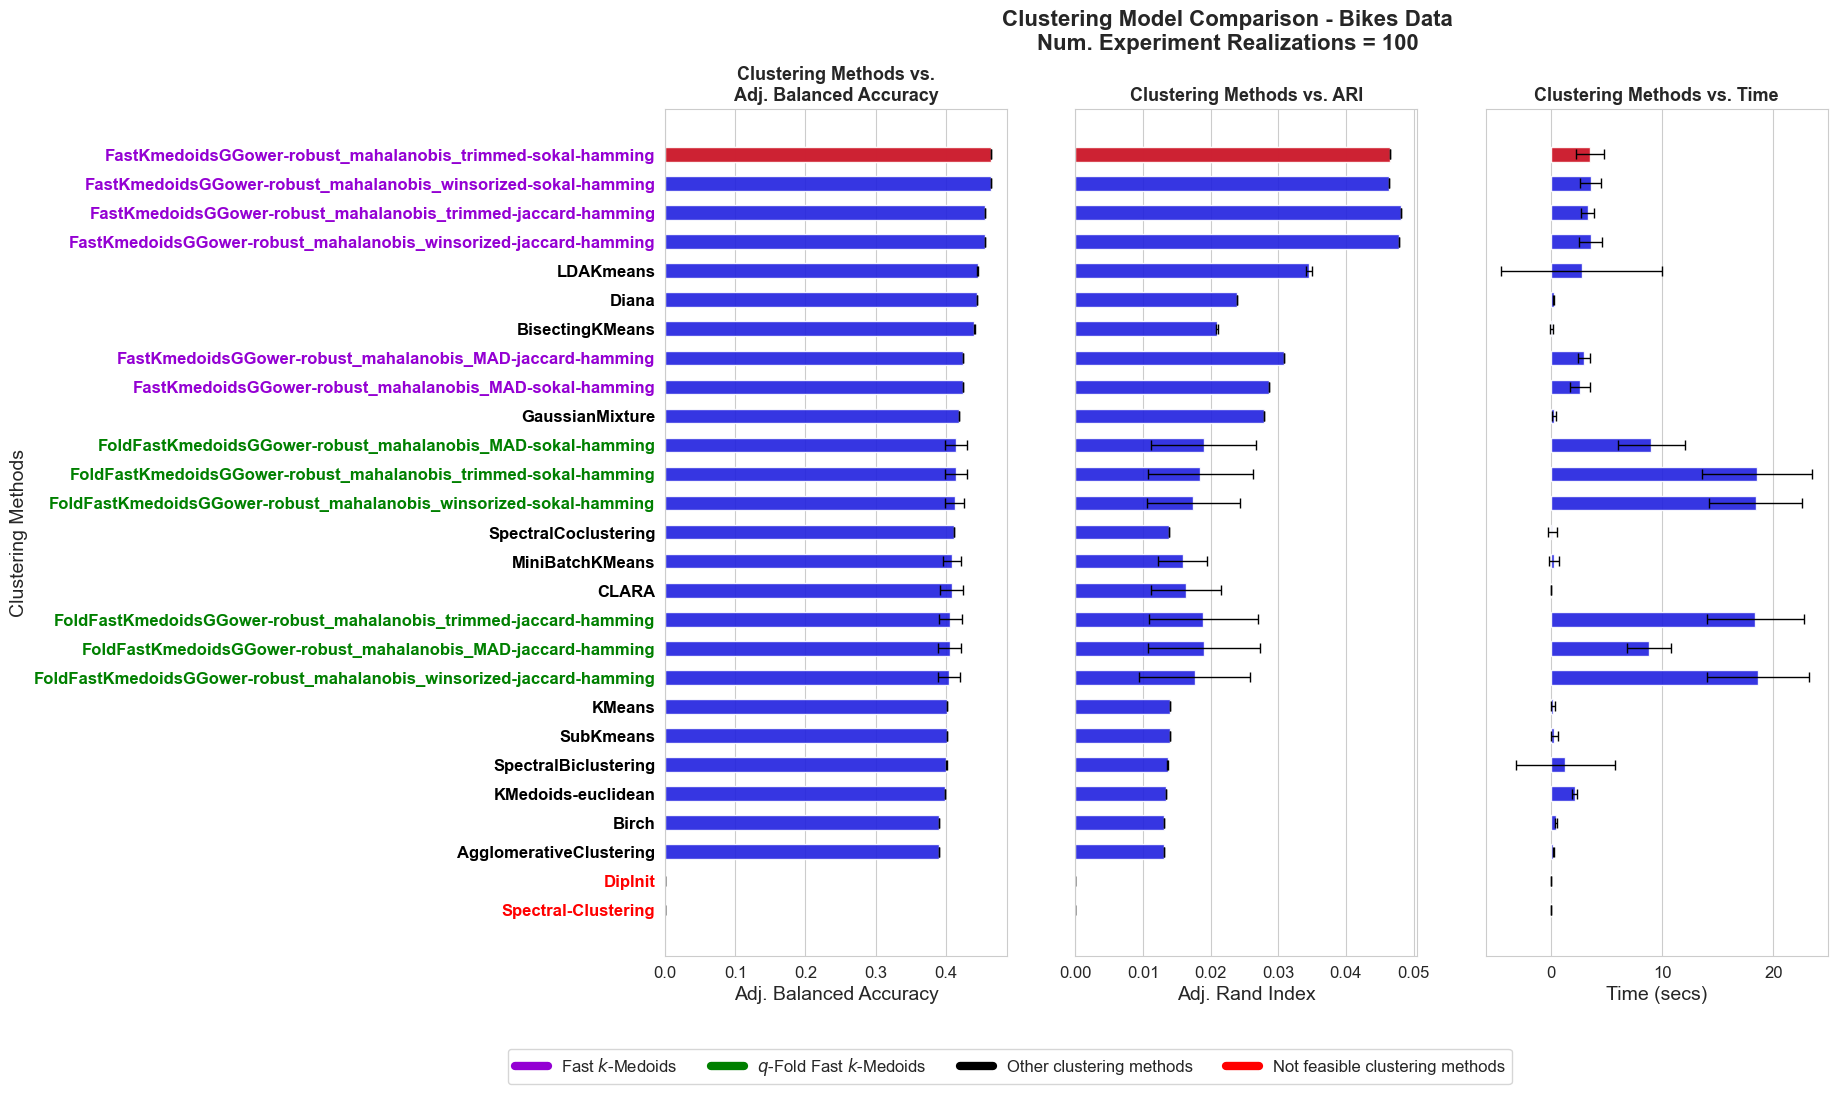

In [21]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

# Añadir barras de error manualmente
axes[0].errorbar(
    x=avg_adj_accuracy[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_adj_acc[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[1].errorbar(
    x=avg_ari[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_ari[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[2].errorbar(
    x=avg_time[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_time[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Balanced Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs.\nAdj. Balanced Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - Bikes Data\nNum. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_bikes_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [14]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [15]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,3.523043,0.464063,0.046588,0.000000e+00,6.938894e-18,1.290238
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,3.564835,0.463838,0.046342,2.220446e-16,1.387779e-17,0.966896
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,3.292952,0.456174,0.048162,1.665335e-16,6.938894e-18,0.563668
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,3.592573,0.455498,0.047786,5.551115e-17,1.387779e-17,1.036751
LDAKmeans,2.764221,0.445198,0.034497,7.663349e-04,4.455212e-04,7.236461
Diana,0.235837,0.444695,0.023891,1.665335e-16,0.000000e+00,0.049012
BisectingKMeans,0.052342,0.440546,0.020884,3.651103e-04,1.315474e-04,0.119034
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,2.981045,0.424251,0.030835,1.665335e-16,3.469447e-18,0.548722
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,2.610557,0.424237,0.028647,1.110223e-16,0.000000e+00,0.872241


In [16]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,3.292952,0.456174,0.048162,1.665335e-16,6.938894e-18,0.563668
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,3.592573,0.455498,0.047786,5.551115e-17,1.387779e-17,1.036751
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,3.523043,0.464063,0.046588,0.000000e+00,6.938894e-18,1.290238
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,3.564835,0.463838,0.046342,2.220446e-16,1.387779e-17,0.966896
LDAKmeans,2.764221,0.445198,0.034497,7.663349e-04,4.455212e-04,7.236461
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,2.981045,0.424251,0.030835,1.665335e-16,3.469447e-18,0.548722
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,2.610557,0.424237,0.028647,1.110223e-16,0.000000e+00,0.872241
GaussianMixture,0.235207,0.419211,0.027854,5.551115e-17,0.000000e+00,0.181745
Diana,0.235837,0.444695,0.023891,1.665335e-16,0.000000e+00,0.049012


### MDS visualization

In [17]:
random_state_mds = 35084

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.3, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='jaccard', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [18]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'KMedoids-euclidean']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

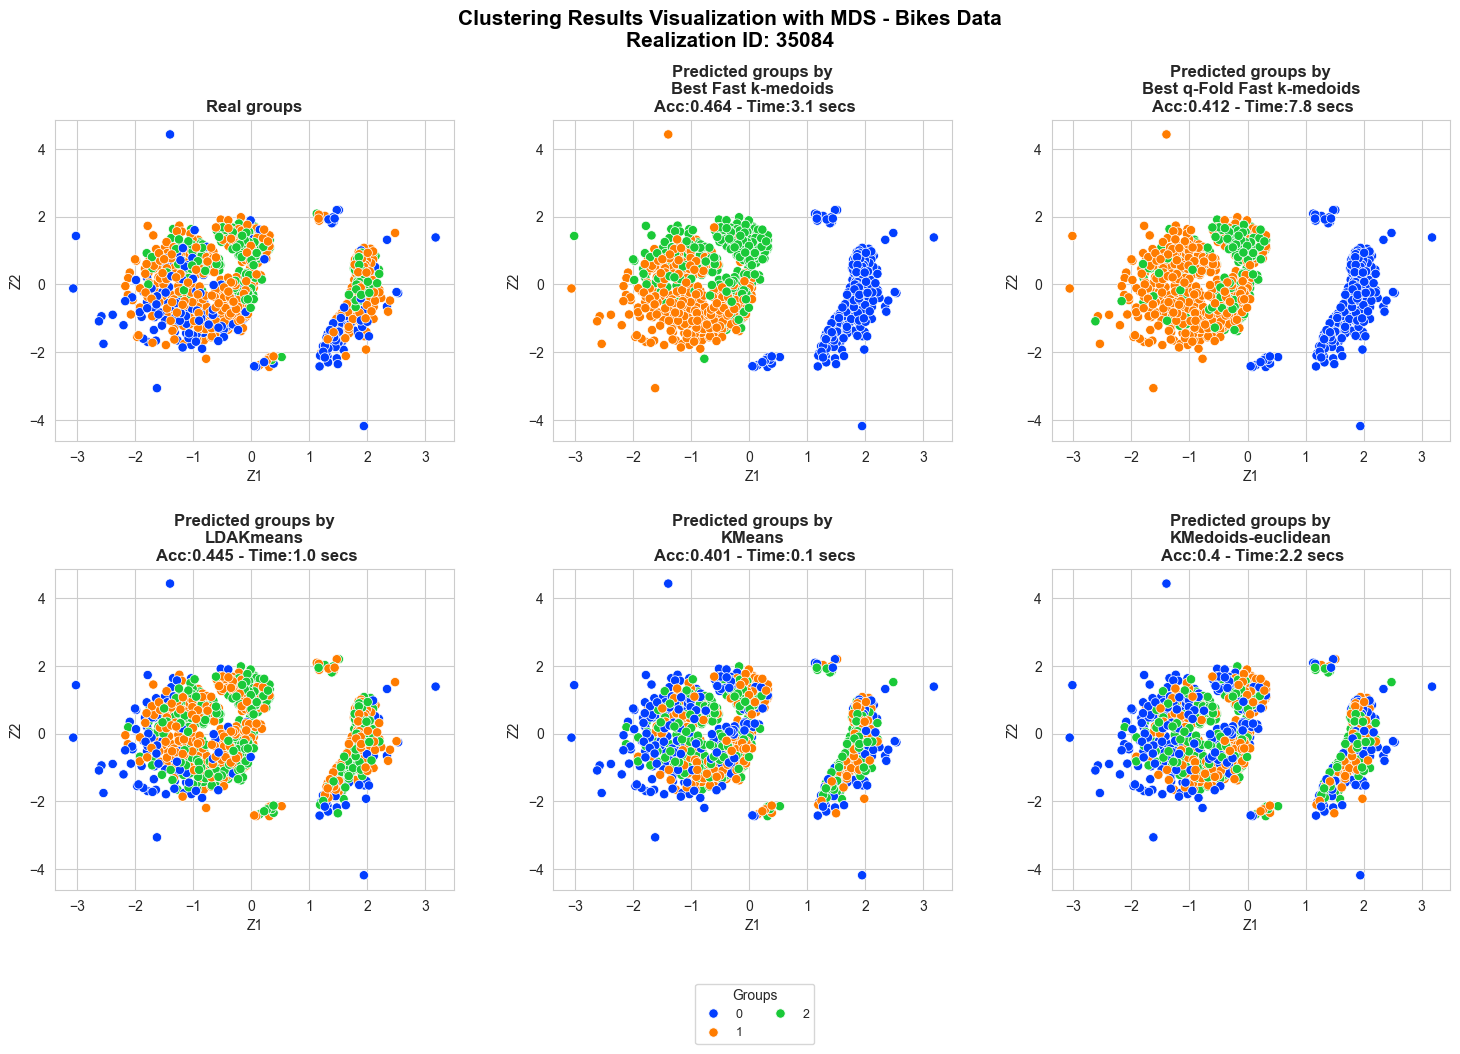

In [20]:
plot_filename = f'mds_plot_exp_4_bikes_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'bikes')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Bikes Data\nRealization ID: {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.67,-1.9), 
                                     title_size=15, title_weight='bold', 
                                     subtitles_size=12,
                                     points_size=45, title_height=0.99, 
                                     wspace=0.25, hspace=0.4, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)

**TO DO**
- Probar resultados con balanced acc 
- Probar resultados con 2 clusters en vez de 3
- Meter ncluster como parte del output en el processing de todos los real data